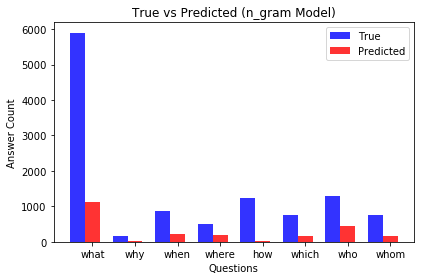

In [16]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 8

means_frank = (5895, 158, 857, 499, 1241, 748, 1280, 748)
means_guido = (1123, 13, 225, 193,9,159,446,159)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, means_frank, bar_width,
                 alpha=opacity,
                 color='b',
                 label='True')
 
rects2 = plt.bar(index + bar_width, means_guido, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Predicted')
 
plt.xlabel('Questions')
plt.ylabel('Answer Count')
plt.title('True vs Predicted (n_gram Model)')
plt.xticks(index + bar_width, ('what','why','when','where','how','which','who','whom'))
plt.legend()
 
plt.tight_layout()
plt.show()

In [2]:
import json
import pickle
import nltk
import numpy as np
from sklearn.feature_extraction import DictVectorizer
import sklearn as sk
from sklearn.metrics import *
from nltk import word_tokenize
from collections import Counter
from gensim.models import word2vec 
from nltk.corpus import stopwords
from keras.models import Sequential
from gensim.similarities import WmdSimilarity
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense, Activation,LSTM,Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [33]:
def make_w2v(filename, w2v_model):
    lines = []
    with open(filename,"rb") as f:
        while 1:
            try:
                lines.append(pickle.load(f))
            except EOFError:
                break
    dicts = []
    labels = []
    for line in lines:
        d = {}
        for word in line[0].split():
            if word in w2v_model.wv:
                w2v_arr = w2v_model.wv[word]
                for i in range(0,len(w2v_arr)):
                    d['w2v_'+ word + '_' + str(i)] = w2v_arr[i]
        dicts.append(d)
        labels.append(line[1])
    return dicts, np.array(labels)

In [16]:
def read_features(filename):
    vector = []
    with open(filename,"rb") as f:
        while 1:
            try:
                vector.append(pickle.load(f))
            except EOFError:
                break
    dicts = []
    labels = []
    for v in vector:
        dicts.append(v[0])
        labels.append(v[1])
    return dicts, np.array(labels)

In [17]:
w2v_model = word2vec.Word2Vec.load("w2v_model_proj")
#X_features_val, y_val = read_features("dev_set.pkl")

In [45]:
vec = DictVectorizer()

In [46]:
X_features_train, y_train = make_w2v("train_set.pkl",w2v_model)

In [47]:
X_train = vec.fit_transform(X_features_train)
print(X_train.shape,y_train.shape)

(70732, 603850) (70732,)


In [48]:
X_features_val, y_val = make_w2v("dev_set.pkl",w2v_model)
X_val = vec.transform(X_features_val)
print(X_val.shape,y_val.shape)

(7207, 603850) (7207,)


In [49]:
X_features_test, y_test = make_w2v("test_set.pkl",w2v_model)
X_test = vec.transform(X_features_test)
print(X_test.shape,y_test.shape)

(8485, 603850) (8485,)


In [50]:
#Logistic Regression
clf = LogisticRegression(random_state=2,C=0.1,class_weight="balanced",penalty='l1')
clf.fit(X_train,y_train)
acc = cross_val_score(clf,X_train,y_train,cv=10)
print("Average Training Accuracy",np.mean(acc))
y_pred = clf.predict(X_test)
"""
y_proba = clf.predict_proba(X_test)
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        print(X_features_test[i], y_test[i], y_proba[i][1])
"""
print(sk.metrics.classification_report(y_test,y_pred))
print ("\nPrecision of Correct Answer: ", sk.metrics.precision_score(y_test, y_pred))
print ("\nRecall of Correct Answer: ", sk.metrics.recall_score(y_test, y_pred))
print ("\nf1_score of Correct Answer: ", sk.metrics.f1_score(y_test, y_pred))
print ("\nconfusion_matrix")
print (sk.metrics.confusion_matrix(y_test, y_pred))

Average Training Accuracy 0.569855428671
             precision    recall  f1-score   support

          0       0.81      0.60      0.69      6562
          1       0.28      0.53      0.36      1923

avg / total       0.69      0.58      0.62      8485


Precision of Correct Answer:  0.278711098871

Recall of Correct Answer:  0.526261050442

f1_score of Correct Answer:  0.364422038171

confusion_matrix
[[3943 2619]
 [ 911 1012]]


In [ ]:
#Error Analysis
for i,y in enumerate(y_pred):
    print(X_features_test[i])
    if y == 1:
        print("True")
    else:
        print("False")

In [ ]:
#MLP Classifier
clf = MLPClassifier(random_state=1, solver="lbfgs", hidden_layer_sizes=(2,1))
clf.fit(X_train,y_train)
acc = cross_val_score(clf,X_train,y_train,cv=10)
print("Average Training Accuracy",np.mean(acc))
y_pred = clf.predict(X_test)
print(sk.metrics.classification_report(y_test,y_pred))
print ("\nPrecision of Correct Answer: ", sk.metrics.precision_score(y_test, y_pred))
print ("\nRecall of Correct Answer: ", sk.metrics.recall_score(y_test, y_pred))
print ("\nf1_score of Correct Answer: ", sk.metrics.f1_score(y_test, y_pred))
print ("\nconfusion_matrix")
print (sk.metrics.confusion_matrix(y_test, y_pred))

In [ ]:
X_features_train, y_train1 = read_features("train_set.pkl")
X_train1 = vec.fit_transform(X_features_train)
print(X_train1.shape,y_train1.shape)

In [ ]:
X_features_test, y_test1 = read_features("test_set.pkl")
X_test1 = vec.transform(X_features_test)
print(X_test1.shape,y_test1.shape)

In [ ]:
##########################################
####### Keras sequential method ##########
##########################################
from keras.utils.np_utils import to_categorical

X_train = X_train1.toarray()
X_test = X_test1.toarray()


y_true = y_test1

y_train = to_categorical(y_train1)
y_test = to_categorical(y_test1)

print(len(X_train),len(y_train),len(X_test),len(y_test))

model=Sequential()
model.add(Dense(20,input_dim=X_train.shape[1]))
model.add(Activation('relu'))
#print(model.output_shape)
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.fit(X_train[:25000],y_train[:25000],epochs=2)
loss_metrics=model.evaluate(X_test,y_test)
classes=model.predict(X_test)
score = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

y_pred = [np.argmax(c) for c in classes]
print(Counter([np.argmax(c) for c in classes]))
print(classification_report(y_true,y_pred))
print("\nPrecision", sk.metrics.precision_score(y_true, y_pred))
print("\nRecall", sk.metrics.recall_score(y_true, y_pred))
print("\nf1_score", sk.metrics.f1_score(y_true, y_pred))
print("\nconfusion_matrix")
print(sk.metrics.confusion_matrix(y_true, y_pred))

In [ ]:
#######################################
######## Keras LSTM method ############
#######################################
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model=Sequential()
model.add(Embedding(X_train.shape[1],output_dim=2))
model.add(LSTM(10,input_dim=X_train.shape[1]))
model.add(Activation('relu'))
print(model.output_shape)
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])

model.fit(X_train[:2500],y_train[:2500],epochs=1)
loss_metrics=model.evaluate(X_test,y_test)
classes=model.predict(X_test)
score = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))